# Proyecto de Pronóstico Multivariable Mensual

Este repositorio contiene un Jupyter Notebook (sdet_multivariable_mensual.ipynb) para el pronóstico mensual de PM2.5 en una estación objetivo, utilizando las lecturas de PM2.5 de otras estaciones como variables exógenas, y generando además intervalos conformales.

# Estructura de secciones en el Notebook

Preprocesamiento: lectura de datos, conversión de fechas, limpieza.

División de datos: corte temporal para train y test.

Exógenas: definición y validación de columnas futuras.

Modelos:

LSTM: modelo recurrente con capas codificadoras y decodificadoras.

Prophet: modelo aditivo de series temporales con detección de cambios de tendencia y estacionalidades flexibles.

TBATS: modelos estadísticos de Box–Cox, ARMA y tendencias amortiguadas.

In [63]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss

In [64]:
import pandas as pd
import numpy as np

# Plot
import matplotlib.pyplot as plt

# MLforecast
from mlforecast import MLForecast
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean, rolling_std
from utilsforecast.preprocessing import fill_gaps


In [65]:
import glob
import os
import pandas as pd

# Cambiar al directorio donde están los archivos
os.chdir(r'C:\MASTER_ANALITICA\tesis\Trabajo para tesis\LATAM\model24')

# Corregir el patrón para incluir todos los archivos deseados
filenames = glob.glob('datos_imputados_completos_chile_20_24.csv')

# Inicializar DataFrame vacío
base_consolidada = pd.DataFrame([])

# Leer y concatenar todos los archivos
for file in filenames:
    print(file)
    temp = pd.read_csv(
        file,
        parse_dates=['fecha_hora'],
        dayfirst=True
    )
    base_consolidada = pd.concat([base_consolidada, temp], ignore_index=True)

# Mostrar rango de fechas final
print(base_consolidada['fecha_hora'].min(), '→', base_consolidada['fecha_hora'].max())

datos_imputados_completos_chile_20_24.csv
2020-01-01 00:00:00 → 2024-12-31 00:00:00


In [66]:
base_pm25 =  base_consolidada.copy()

In [67]:
base_pm25.columns = base_pm25.columns.str.replace(',', '_', regex=False)

In [68]:
base_pm25.rename(columns={'lascondes_mp25':'lascondes_pm25','parque_mp25':'parque_pm25', 'pudahuel_mp25':'pudahuel_pm25', 'puentealto_mp25':'puentealto_pm25', 'talagante_mp25':'talagante_pm25'}, inplace=True)

In [69]:
base_pm25.head()

,fecha_hora,cerronavia_pm25,elbosque_pm25,laflorida_pm25,lascondes_pm25,parque_pm25,pudahuel_pm25,puentealto_pm25,talagante_pm25
0,2020-01-01 00:00:00,38.0,56.0,27.0,26.0,24.0,26.0,22.0,26.0
1,2020-01-01 01:00:00,29.0,35.0,50.0,17.0,24.0,16.0,45.0,18.0
2,2020-01-01 02:00:00,22.0,33.0,48.0,16.0,26.0,11.0,29.0,16.0
3,2020-01-01 03:00:00,18.0,18.0,32.0,15.0,16.0,18.0,29.0,16.0
4,2020-01-01 04:00:00,16.0,22.0,33.0,13.0,14.0,13.0,28.0,14.0


In [70]:
base_pm25['fecha_hora'] = pd.to_datetime(base_pm25['fecha_hora'])

# 2. Establecer 'fecha_hora' como índice
base_pm25.set_index('fecha_hora', inplace=True)

# 3. Ahora sí puedes hacer el resample mensual
base_pm25 = base_pm25.resample('M').mean().reset_index()

In [71]:
data= base_pm25.copy()

In [72]:
data.isnull().sum()/len(data)*100

fecha_hora         0.0
cerronavia_pm25    0.0
elbosque_pm25      0.0
laflorida_pm25     0.0
lascondes_pm25     0.0
parque_pm25        0.0
pudahuel_pm25      0.0
puentealto_pm25    0.0
talagante_pm25     0.0
dtype: float64

# lstm 

In [73]:
data = data.rename(columns={'fecha_hora': 'ds', 'cerronavia_pm25': 'y'})
# Añades unique_id con el mismo valor para todas las filas
data['unique_id'] = 'cerronavia_pm25'

data.head()

,ds,y,elbosque_pm25,laflorida_pm25,lascondes_pm25,parque_pm25,pudahuel_pm25,puentealto_pm25,talagante_pm25,unique_id
0,2020-01-31,16.758065,16.865591,15.776613,14.112903,14.951613,14.399194,16.542339,9.190457,cerronavia_pm25
1,2020-02-29,19.071839,19.457040,19.458190,14.995690,16.521552,15.271552,17.979885,2.000000,cerronavia_pm25
2,2020-03-31,17.931452,20.754032,13.915591,14.246371,16.485484,15.865591,17.501344,2.000000,cerronavia_pm25
3,2020-04-30,26.645833,26.981944,22.198611,17.005556,20.961111,24.133333,22.513889,2.000000,cerronavia_pm25
4,2020-05-31,42.177419,38.241935,30.652151,20.971774,29.896505,39.193548,30.461022,2.000000,cerronavia_pm25


In [74]:
export =data.copy()

In [75]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM



# 2) Asegúrate de que ds sea datetime
export['ds'] = pd.to_datetime(export['ds'])

# 3) Divide en train/test usando la fecha de corte
fecha_corte = pd.to_datetime('2023-12-31')
train = export[export.ds <= fecha_corte]
test  = export[export['ds'] >  fecha_corte]


# 5) Define tu lista completa de exógenas futuras
futr_list = [
    'elbosque_pm25','laflorida_pm25','lascondes_pm25',
    'parque_pm25','pudahuel_pm25','puentealto_pm25','talagante_pm25'
]

# 6) Filtra solo las que realmente estén en train/test
presentes = [c for c in futr_list if c in train.columns]
faltantes = set(futr_list) - set(presentes)
if faltantes:
    print(f"Advertencia: faltan estas columnas y se omitirán del modelo:\n  {faltantes}")

# -----------------------------
# 7) Configura el modelo LSTM
# -----------------------------
horizon = 12
models = [
    LSTM(
        h                   = horizon,
        input_size          = -1,
        scaler_type         = 'robust',
        encoder_n_layers    = 2,
        encoder_hidden_size = 128,
        context_size        = 10,
        decoder_hidden_size = 128,
        decoder_layers      = 2,
        max_steps           = 20,
        futr_exog_list      = presentes,
        # hist_exog_list    = ['y_lag12'],
        # stat_exog_list    = ['airline1'],
    )
]

# -----------------------------
# 8) Crea e instancia NeuralForecast
# -----------------------------
nf = NeuralForecast(
    models = models,
    freq   = 'm'   
)




Seed set to 1


In [76]:
nf.fit(df=train)


c:\Users\eusou\anaconda3\envs\wprophet\lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 199 K  | train
4 | context_adapter | Linear        | 25.6 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
227 K     Trainable params
0         Non-trainable params
227 K     Total params
0.909     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval m

Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s, v_num=139, train_loss_step=0.624, train_loss_epoch=0.624]

`Trainer.fit` stopped: `max_steps=20` reached.


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s, v_num=139, train_loss_step=0.624, train_loss_epoch=0.624]


In [77]:
missing = nf.get_missing_future(futr_df=test)
print(missing)


Empty DataFrame
Columns: [unique_id, ds]
Index: []


In [78]:
# -----------------------------
# 10) Genera pronóstico sobre test
# -----------------------------
forecast_lstm = nf.predict(futr_df=test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.60it/s] 


c:\Users\eusou\anaconda3\envs\wprophet\lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [79]:
test.head()

,ds,y,elbosque_pm25,laflorida_pm25,lascondes_pm25,parque_pm25,pudahuel_pm25,puentealto_pm25,talagante_pm25,unique_id
48,2024-01-31,11.160349,14.388441,15.295027,15.185484,13.684812,11.946237,12.848790,11.252016,cerronavia_pm25
49,2024-02-29,11.765805,13.771552,16.938218,15.186063,13.697557,13.063218,12.734195,12.303161,cerronavia_pm25
50,2024-03-31,12.098118,16.942204,15.862097,12.241398,11.610215,14.027957,15.825941,12.662097,cerronavia_pm25
51,2024-04-30,16.131944,21.927778,18.433333,13.638333,15.935833,16.353611,18.559722,13.239583,cerronavia_pm25
52,2024-05-31,42.515457,37.890457,29.946237,19.027151,29.538978,38.738978,26.679435,36.845430,cerronavia_pm25


In [80]:
forecast_lstm.head()

,ds,LSTM
unique_id,,
cerronavia_pm25,2024-01-31,14.887485
cerronavia_pm25,2024-02-29,14.489846
cerronavia_pm25,2024-03-31,18.144951
cerronavia_pm25,2024-04-30,25.656910
cerronavia_pm25,2024-05-31,37.399101


In [81]:
forecast_lstm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, cerronavia_pm25 to cerronavia_pm25
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      12 non-null     datetime64[ns]
 1   LSTM    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 240.0+ bytes


In [82]:
dark_style = {
    'figure.facecolor': '333333', ##212946'
    'axes.facecolor': '333333',
    'savefig.facecolor':'333333',
    'axes.grid': True,
    'axes.grid.which': 'both',
   
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

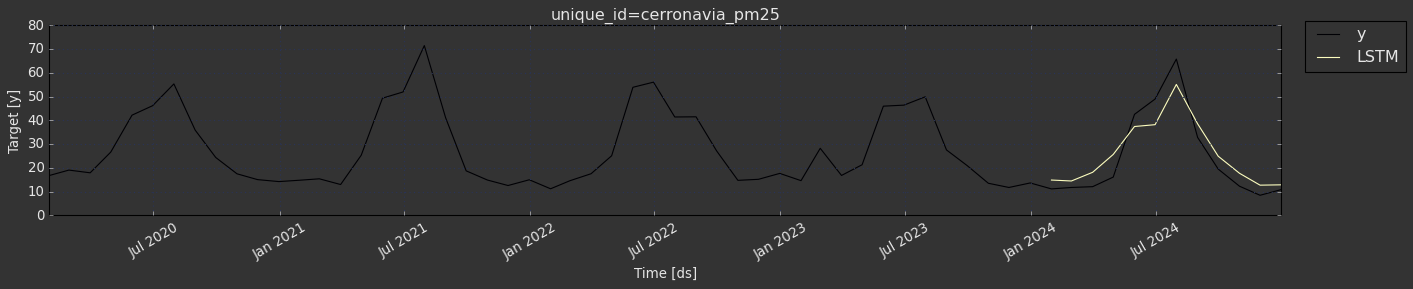

In [83]:
plot_series(data, forecast_lstm.reset_index(),  max_insample_length = 300,   palette="magma" )

In [84]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 48 to 59
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ds               12 non-null     datetime64[ns]
 1   y                12 non-null     float64       
 2   elbosque_pm25    12 non-null     float64       
 3   laflorida_pm25   12 non-null     float64       
 4   lascondes_pm25   12 non-null     float64       
 5   parque_pm25      12 non-null     float64       
 6   pudahuel_pm25    12 non-null     float64       
 7   puentealto_pm25  12 non-null     float64       
 8   talagante_pm25   12 non-null     float64       
 9   unique_id        12 non-null     object        
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 1.0+ KB


In [85]:
# Asegúrate de que ambas tablas tengan las mismas columnas datetime y unique_id
export['ds']        = pd.to_datetime(export['ds'])
forecast_lstm['ds'] = pd.to_datetime(forecast_lstm['ds'])

# Merge: left=export (histórico), right=forecast_lstm (predicción)
df_merged = export.merge(
    forecast_lstm[['ds','LSTM']],
    on=['ds'],
    how='inner'
)

# Reordena columnas si quieres
resultado = df_merged[['ds','LSTM']]

resultado.head(12)


,ds,LSTM
0,2024-01-31,14.887485
1,2024-02-29,14.489846
2,2024-03-31,18.144951
3,2024-04-30,25.656910
4,2024-05-31,37.399101
5,2024-06-30,38.171627
6,2024-07-31,55.097881
7,2024-08-31,38.544220
8,2024-09-30,24.910122
9,2024-10-31,17.740103


plt.style.use('classic')  # Utilizamos el estilo “classic” de Matplotlib
dark_style = {
    'axes.facecolor': '#f3aba8'  # Color de fondo de los ejes
}
plt.rcParams.update(dark_style)


# 'export' contiene la serie histórica y 'forecast_lstm' los valores pronosticados
plot_series(export, forecast_lstm.reset_index(drop=True), palette='inferno')


In [86]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)
from utilsforecast.evaluation import evaluate

def evaluate_performance(v_hist, v_true, v_pred, models):
    y_true = pd.merge(v_true, v_pred, how='left', on=['ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(
                    y_true['y'].values,
                    y_true[model].values,
                    v_hist['y'].values,
                    seasonality=24
                )
            else:
                evaluation[model][metric_name] = metric(
                    y_true['y'].values,
                    y_true[model].values
                )
    return pd.DataFrame(evaluation).T

# Ejecutar la evaluación para el modelo LSTM
evaluate_performance(train, test, resultado, models=["LSTM"])


,mae,mape,mase,rmse,smape
LSTM,5.953901,31.157405,1.076114,6.576782,26.981902


# Prophet

In [87]:
import pandas as pd
from prophet import Prophet

# Lista para acumular pronósticos
p = list()

# Iterar por cada serie identificada en 'unique_id'
for unique_id in train['unique_id'].unique():
    print('unique_id:', unique_id)
    
    # Subconjuntos de entrenamiento y prueba para esta serie
    train_ = train.loc[train['unique_id'] == unique_id]
    test_  = test .loc[test ['unique_id'] == unique_id]

    # 1) Definir y configurar el modelo Prophet
    m = Prophet(
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
    )

    # 2) Agregar variables exógenas
    m.add_regressor('elbosque_pm25')
    m.add_regressor('laflorida_pm25')
    m.add_regressor('lascondes_pm25')
    m.add_regressor('parque_pm25')
    m.add_regressor('pudahuel_pm25')
    m.add_regressor('puentealto_pm25')
    m.add_regressor('talagante_pm25')

    # 3) Entrenar el modelo con los datos históricos
    m.fit(train_)

    # 4) Construir el DataFrame de fechas futuras en las que predecir
    future = m.make_future_dataframe(
        periods=12,       # horizon de 24 pasos
        include_history=False,
        freq='m'         # frecuencia mensual al inicio de mes
    )
    # Unir las exógenas de test al DataFrame futuro
    future = future.merge(
        test_[['ds', 'elbosque_pm25', 'laflorida_pm25', 'lascondes_pm25',
       'parque_pm25', 'pudahuel_pm25', 'puentealto_pm25', 'talagante_pm25']],
        on='ds',
        how='left'
    )

    # 5) Obtener el pronóstico
    forecast = m.predict(future)
    forecast['unique_id'] = unique_id

    # 6) Guardar sólo las columnas de interés
    p.append(forecast[['ds', 'yhat', 'unique_id']])

# 7) Concatenar todos los resultados y limpiar valores negativos
p = pd.concat(p, ignore_index=True)
p['yhat'] = p['yhat'].clip(lower=0)

# 8) Hacer merge con los valores reales de test para comparar
p = p.merge(test, on=['ds', 'unique_id'], how='left')


unique_id: cerronavia_pm25


22:30:15 - cmdstanpy - INFO - Chain [1] start processing
22:30:16 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
# Veamos el resultado del Forecasting
forecast.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,unique_id
0,2024-01-31,-1.674412,11.460029,12.761635,-1.680817,-1.666981,13.788970,13.788970,13.788970,26.445023,...,1.175610,1.175610,-1.542067,-1.542067,-1.542067,0.0,0.0,0.0,12.114558,cerronavia_pm25
1,2024-02-29,-1.868216,12.785631,14.024108,-1.889730,-1.842376,15.289274,15.289274,15.289274,26.445023,...,-0.289435,-0.289435,-0.273215,-0.273215,-0.273215,0.0,0.0,0.0,13.421058,cerronavia_pm25
2,2024-03-31,-2.075386,11.340197,12.653455,-2.117960,-2.025318,14.069806,14.069806,14.069806,26.445023,...,-1.419613,-1.419613,-0.928391,-0.928391,-0.928391,0.0,0.0,0.0,11.994420,cerronavia_pm25
3,2024-04-30,-2.275873,13.810454,15.096762,-2.341856,-2.196080,16.744625,16.744625,16.744625,26.445023,...,0.049366,0.049366,-0.939281,-0.939281,-0.939281,0.0,0.0,0.0,14.468752,cerronavia_pm25
4,2024-05-31,-2.483043,36.632996,37.860913,-2.581258,-2.369953,39.697794,39.697794,39.697794,26.445023,...,0.179981,0.179981,-0.590742,-0.590742,-0.590742,0.0,0.0,0.0,37.214752,cerronavia_pm25


In [89]:
p # el pronostico con Prophet con las exógenas

,ds,yhat,unique_id,y,elbosque_pm25,laflorida_pm25,lascondes_pm25,parque_pm25,pudahuel_pm25,puentealto_pm25,talagante_pm25
0,2024-01-31,12.114558,cerronavia_pm25,11.160349,14.388441,15.295027,15.185484,13.684812,11.946237,12.848790,11.252016
1,2024-02-29,13.421058,cerronavia_pm25,11.765805,13.771552,16.938218,15.186063,13.697557,13.063218,12.734195,12.303161
2,2024-03-31,11.994420,cerronavia_pm25,12.098118,16.942204,15.862097,12.241398,11.610215,14.027957,15.825941,12.662097
3,2024-04-30,14.468752,cerronavia_pm25,16.131944,21.927778,18.433333,13.638333,15.935833,16.353611,18.559722,13.239583
4,2024-05-31,37.214752,cerronavia_pm25,42.515457,37.890457,29.946237,19.027151,29.538978,38.738978,26.679435,36.845430
5,2024-06-30,43.233942,cerronavia_pm25,48.958333,41.697222,29.125694,13.556528,33.092361,46.066667,24.698611,36.856944
6,2024-07-31,64.890014,cerronavia_pm25,65.774194,58.297715,45.403226,32.280914,47.765457,60.818548,41.288306,51.566532
7,2024-08-31,20.632094,cerronavia_pm25,32.806183,33.658602,29.338575,26.646774,23.084274,22.260906,25.886425,21.616263
8,2024-09-30,15.817028,cerronavia_pm25,19.495833,23.381250,20.270833,16.981250,16.968056,17.519167,18.712500,13.584722
9,2024-10-31,10.479482,cerronavia_pm25,12.297715,16.885753,15.426747,14.516129,12.694220,12.896505,14.396505,9.467742


In [90]:
# Unir los resultados de LSTM y Prophet

resultado = resultado.merge(p[["yhat", "ds", "unique_id"]])
resultado.rename(columns={"yhat": "Prophet"},inplace=True)
resultado




,ds,LSTM,Prophet,unique_id
0,2024-01-31,14.887485,12.114558,cerronavia_pm25
1,2024-02-29,14.489846,13.421058,cerronavia_pm25
2,2024-03-31,18.144951,11.994420,cerronavia_pm25
3,2024-04-30,25.656910,14.468752,cerronavia_pm25
4,2024-05-31,37.399101,37.214752,cerronavia_pm25
5,2024-06-30,38.171627,43.233942,cerronavia_pm25
6,2024-07-31,55.097881,64.890014,cerronavia_pm25
7,2024-08-31,38.544220,20.632094,cerronavia_pm25
8,2024-09-30,24.910122,15.817028,cerronavia_pm25
9,2024-10-31,17.740103,10.479482,cerronavia_pm25


In [91]:
print(
    evaluate_performance(
        train,
        test,
        resultado,
        models=["LSTM", "Prophet"]
    )
)

             mase       mae       mape      rmse      smape
LSTM     1.076114  5.953901  31.157405  6.576782  26.981902
Prophet  0.595784  3.296340  15.727255  4.553396  17.620554


In [92]:
# Visualizando las predicciones de Prophet
Y_hat_prophet = p.copy()
Y_hat_prophet = Y_hat_prophet[['unique_id', 'ds', 'yhat']]
Y_hat_prophet = Y_hat_prophet.rename(columns={'yhat': 'Prophet'})
Y_hat_prophet


,unique_id,ds,Prophet
0,cerronavia_pm25,2024-01-31,12.114558
1,cerronavia_pm25,2024-02-29,13.421058
2,cerronavia_pm25,2024-03-31,11.994420
3,cerronavia_pm25,2024-04-30,14.468752
4,cerronavia_pm25,2024-05-31,37.214752
5,cerronavia_pm25,2024-06-30,43.233942
6,cerronavia_pm25,2024-07-31,64.890014
7,cerronavia_pm25,2024-08-31,20.632094
8,cerronavia_pm25,2024-09-30,15.817028
9,cerronavia_pm25,2024-10-31,10.479482


In [93]:
plt.style.use('classic')  # fivethirtyeight · grayscale · classic
dark_style = {
    'axes.facecolor': '#008080'  # '#484366', '#008080', '#abc9ea', '#98daa7', '#f3aba8', '#d3c3f7', '#f3f3af'
}
plt.rcParams.update(dark_style)

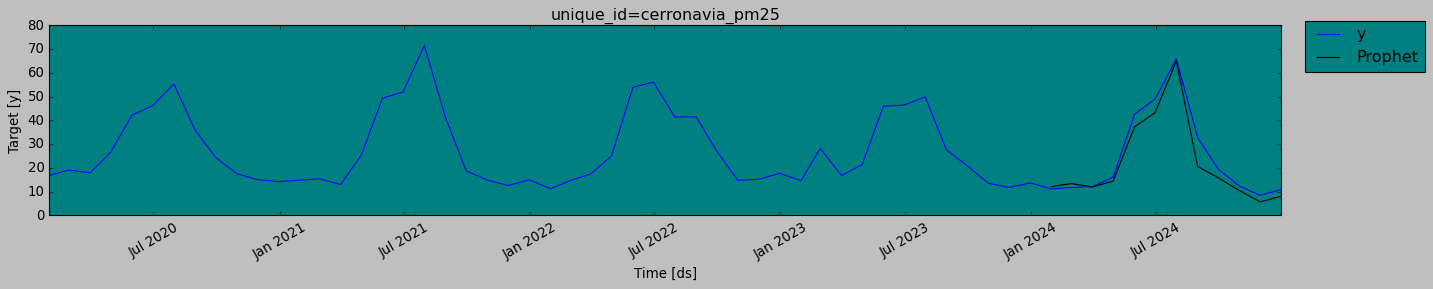

In [94]:
plot_series(export, Y_hat_prophet)

# TBAST

In [95]:
# Dividir en entrenamiento y prueba
train = export[export.ds <= '2023-12-31']
test  = export[export['ds'] > '2023-12-31']

# Para predecir, eliminamos la columna objetivo de test
test.drop('y', axis=1, inplace=True)

# Veamos las formas de ambos conjuntos
train.shape, test.shape



C:\Users\eusou\AppData\Local\Temp\ipykernel_26736\4079635638.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('y', axis=1, inplace=True)


((48, 10), (12, 9))

In [96]:
from statsforecast.models import TBATS
from statsforecast.models import SeasonalNaive

In [97]:
from statsforecast.models import TBATS, SeasonalNaive

season_length = 12
models = [TBATS(season_length=season_length)]



In [98]:
sf = StatsForecast(
    models=models,
    freq='M',
    fallback_model=SeasonalNaive(season_length=season_length),
    n_jobs=-1
)

#sf.fit(df=train)

In [99]:
from statsforecast.utils import ConformalIntervals

intervals = ConformalIntervals(h=12, n_windows=5)

# Ajustar el modelo con intervalos conformales
sf.fit(df=train, prediction_intervals=intervals)

# Realizar predicción con intervalos y variables exógenas (test)
forecast_tbats = sf.predict(h=12, X_df=test)


c:\Users\eusou\anaconda3\envs\wprophet\lib\site-packages\statsforecast\core.py:594: UserWarning: Prediction intervals settings require at least 61 samples, some series have less and will use less windows.
  warnings.warn(
c:\Users\eusou\anaconda3\envs\wprophet\lib\site-packages\statsforecast\core.py:728: UserWarning: Prediction intervals are set but `level` was not provided. Predictions won't have intervals.
  warnings.warn(
c:\Users\eusou\anaconda3\envs\wprophet\lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [100]:
forecast_tbats

,ds,TBATS
unique_id,,
cerronavia_pm25,2024-01-31,13.749890
cerronavia_pm25,2024-02-29,13.947585
cerronavia_pm25,2024-03-31,15.882878
cerronavia_pm25,2024-04-30,22.336174
cerronavia_pm25,2024-05-31,35.262287
cerronavia_pm25,2024-06-30,48.289375
cerronavia_pm25,2024-07-31,46.173000
cerronavia_pm25,2024-08-31,31.243959
cerronavia_pm25,2024-09-30,18.974266


In [101]:
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series  # o la función que uses

# Elegir un estilo base
plt.style.use('classic')  # opciones: 'fivethirtyeight', 'grayscale', 'classic', etc.

# Definir parámetros de estilo personalizados
dark_style = {
    'axes.facecolor': '#484366',   # color de fondo de los ejes
    # puedes añadir más, por ejemplo:
    # 'figure.facecolor': '#008080',
    # 'lines.color': '#abc9ea',
    # 'font.size': 12,
}

# Aplicar estos parámetros globalmente
plt.rcParams.update(dark_style)



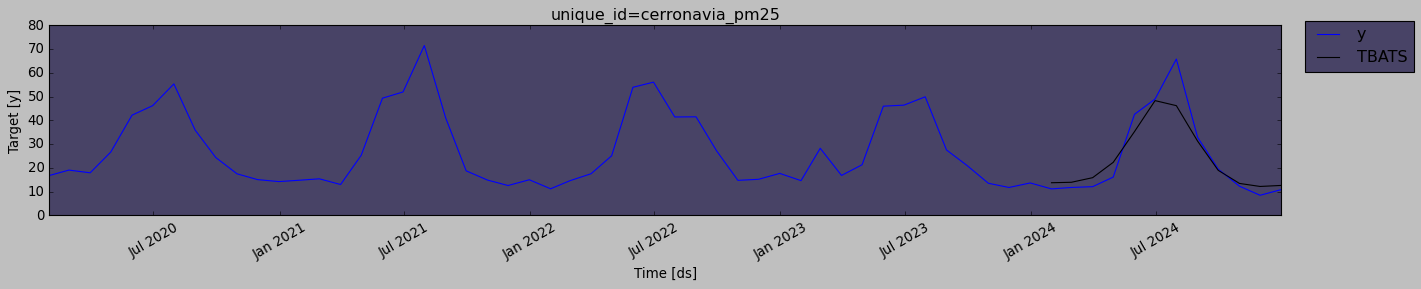

In [102]:
plot_series(export, forecast_tbats.reset_index(drop=False),)

In [103]:
resultado

,ds,LSTM,Prophet,unique_id
0,2024-01-31,14.887485,12.114558,cerronavia_pm25
1,2024-02-29,14.489846,13.421058,cerronavia_pm25
2,2024-03-31,18.144951,11.994420,cerronavia_pm25
3,2024-04-30,25.656910,14.468752,cerronavia_pm25
4,2024-05-31,37.399101,37.214752,cerronavia_pm25
5,2024-06-30,38.171627,43.233942,cerronavia_pm25
6,2024-07-31,55.097881,64.890014,cerronavia_pm25
7,2024-08-31,38.544220,20.632094,cerronavia_pm25
8,2024-09-30,24.910122,15.817028,cerronavia_pm25
9,2024-10-31,17.740103,10.479482,cerronavia_pm25


In [104]:
resultado = resultado.merge(forecast_tbats.reset_index(drop=True))
resultado

,ds,LSTM,Prophet,unique_id,TBATS
0,2024-01-31,14.887485,12.114558,cerronavia_pm25,13.749890
1,2024-02-29,14.489846,13.421058,cerronavia_pm25,13.947585
2,2024-03-31,18.144951,11.994420,cerronavia_pm25,15.882878
3,2024-04-30,25.656910,14.468752,cerronavia_pm25,22.336174
4,2024-05-31,37.399101,37.214752,cerronavia_pm25,35.262287
5,2024-06-30,38.171627,43.233942,cerronavia_pm25,48.289375
6,2024-07-31,55.097881,64.890014,cerronavia_pm25,46.173000
7,2024-08-31,38.544220,20.632094,cerronavia_pm25,31.243959
8,2024-09-30,24.910122,15.817028,cerronavia_pm25,18.974266
9,2024-10-31,17.740103,10.479482,cerronavia_pm25,13.463634


In [105]:
resultado.to_excel('resultados_forecast_santiago_PM25_imputados.xlsx', index=False)

In [106]:
plt.style.use('classic')  # fivethirtyeight  grayscale  classic
dark_style = {
    'axes.facecolor': '#003333'  # '#484366', '#008080', '#abc9ea', '#98daa7', '#f3aba8', '#d3c3f7', '#f3f3af', '#003333'
}
plt.rcParams.update(dark_style)





In [107]:


test = export[export['ds'] > '2022-12-31']
print(evaluate_performance(train, test, resultado, models=["LSTM", "Prophet", "TBATS"]))

         mase       mae       mape      rmse      smape
LSTM      NaN  5.953901  15.578703  6.576782  13.490951
Prophet   NaN  3.296340   7.863627  4.553396   8.810277
TBATS     NaN  4.248810   9.849348  6.598003   9.144894


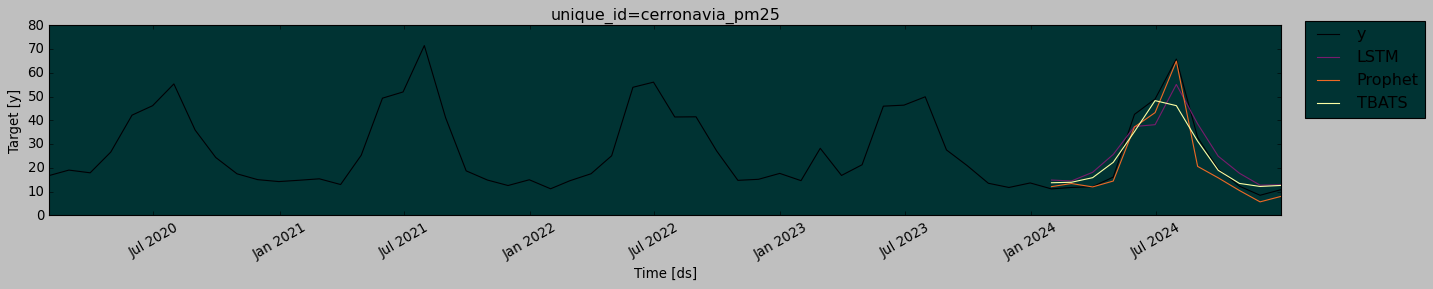

In [108]:
plot_series(export, resultado, palette='inferno')